# Segmenting interlayers

## Content

* [Problem description](#description)
* [Dataset](#dataset)
* [Model architecture](#architecture)
* [Training](#training)
* [Validation](#validation)
* [Criticism](#criticism)
* [Conclusion](#conclusion)
* [Suggestions for improvements](#suggestions)

<a id='description'></a>

# Problem description
Welcome! In this notebook we train a neural network for multiclass-segmentation of *seismic interlayers*. Seismic interlayer is a layer of earth formation between two horizons, labeled by a geophysicist. In a way, a set of several horizons yields coloring of a seismic cube in different interlayers:

<img src="images/facies.png" alt="Drawing" style="width: 600px;"/>

Each seismic interlayer is thought to have roughly similar seismic reflection parameters across all of its volume. Naturally, convolutional neural networks should be able to learn patterns of a specific interlayer. As a result models, trained on a small subset of *ilines/xlines* of a seismic cube are expected to classify interlayers on unseen (during training) parts of seismic cubes with reasonable accuracy.

In [3]:
import sys
import os

In [4]:
sys.path.append('../repos/seismiqb/')

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


<a id='dataset'></a>

# Dataset
we use one seismic cube `P_cube` for training/testing. One can find [here]() a description of cube `P_cube` along with some visualiztions. `P_cube` is a 3d-array of data of shape **[2737, 2599, 2001]** Along with the cube itself come 8 labeled horizons:

Importantly, for training and testing we use different sets of *ilines*: 45% of *ilines* are reserved for training while 35% of *ilines* are used for testing (we intentionally use a margin of *ilines* between training and testing parts to battle overfit).

* Indexing seismic cubes: setting up `SeismicCubeset`

In [6]:
from seismiqb import SeismicCropBatch, SeismicCubeset
from seismiqb.batchflow import FilesIndex, D, L, F, Pipeline, B, V

In [7]:
from seismiqb import make_labels_dict

In [8]:
DATA_DIR = '/notebooks/data/cubes/CUBE_3/'

In [9]:
qbix = FilesIndex(path=os.path.join(DATA_DIR, 'P_cube.hdf5'), no_ext=True)
qbset = SeismicCubeset(qbix)

* load info about seismic cubes into `SeismicCubeset`

In [10]:
qbset.load_geometries()

* load horizon-labels

In [11]:
pref = os.path.join(DATA_DIR, 'HORIZONTS')
horizons_paths = [os.path.join(pref, p) for p in ['prb_B_anon.txt',
                                                  'prb_T_ALL_anon.txt',
                                                  'prb_G_anon.txt',
                                                  'prb_M_anon.txt']]

In [12]:
qbset.load_point_clouds(paths={qbset.indices[0]: horizons_paths})

In [13]:
qbset.load_labels()

* make train/test samplers

In [14]:
qbset.load_samplers()

In [15]:
qbset.train_sample = qbset.sampler.truncate(expr=lambda x: x[:, 1:],
                                            high=[1, 0.45, 1]).sample
qbset.test_sample = qbset.sampler.truncate(expr=lambda x: x[:, 1:],
                                           low=[0, 0.65, 0]).sample

* `pipeline` for loading cube crops and building segmentation-masks

In [16]:
wflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('train_sample'), size=32),
               shape=(128, 1, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).swapaxes(1, 2).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes'))

<a id='architecture'></a>

# Model architecture
We use a convolutional neural network [`U-net`](https://arxiv.org/abs/1505.04597) for interlayers segmentation.

In [17]:
from seismiqb.batchflow.models.tf import UNet
from tqdm import trange
from IPython.display import clear_output

* configuring `unet`

In [18]:
config = {'inputs': dict(cubes={'shape': (128, 128, 1)},
                         masks={'name': 'targets', 'shape': (128, 128),
                                'classes': 10, 'transform': 'ohe'}),
          'initial_block/inputs': 'cubes',
          'loss': 'dice',
          'head': dict(num_classes=10),
          'optimizer': 'Adam'}

<a id='training'></a>

# Training
`U-net` is trained of 2d-crops of seismic cubes of size `[128, 128]`. The training-procedure uses `Adam`-optimizer and is performed on batches of 32 crops.

In [19]:
trainflow = wflow + (Pipeline()
                     .init_variable('loss', default=list())
                     .init_model('static', UNet, 'model', config)
                     .train_model('model', cubes=B('cubes'), masks=B('masks'),
                                  fetches='loss', save_to=V('loss'), mode='a'))

In [20]:
pset = (qbset >> trainflow)

In [ ]:
N_ITERS = 300
tr = trange(N_ITERS, leave=True)
for i in tr:
    pset.next_batch(1, n_epochs=None)
    tr.set_description("current loss is {}".format(pset.get_variable('loss')[-1]))
    clear_output()

current loss is -0.021291878074407578:  57%|█████▋    | 172/300 [2:25:17<1:47:44, 50.51s/it]

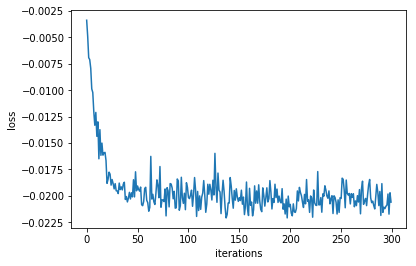

In [26]:
plt.plot(pset.get_variable('loss'))
plt.xlabel('iterations'), plt.ylabel('loss')
plt.show()

# Validation

In this section we look at predictions of our model on *ilines* of the cube we haven't used for training.

In [28]:
from utils import get_lines_range

In [29]:
tflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('test_sample'), size=32),
               shape=(128, 1, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes'))

In [30]:
test_batch = (qbset >> tflow).next_batch(1)

In [32]:
import tensorflow as tf

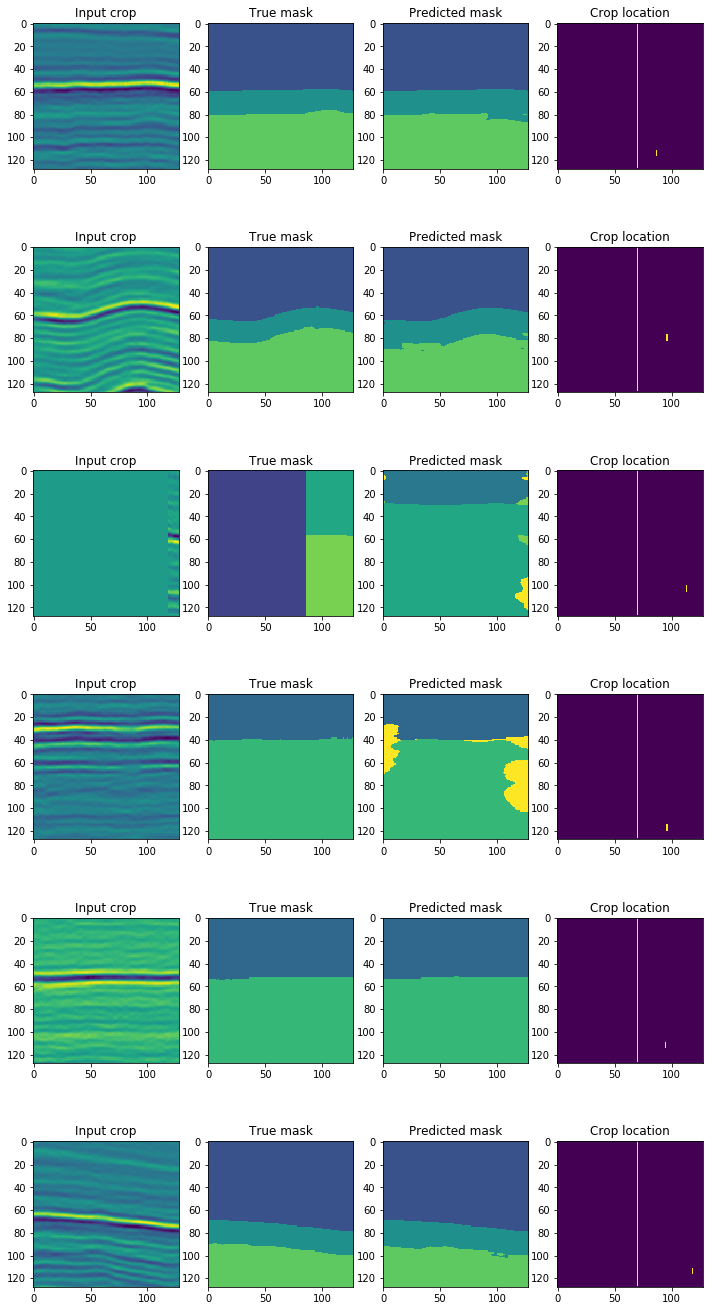

In [33]:
unet = pset.get_model_by_name('model')
targets, predictions = unet.predict(fetches=['targets', tf.nn.softmax(unet.predictions)],
                                    feed_dict={unet.cubes: test_batch.cubes, unet.masks: test_batch.masks})
n_rows = 6
figs, axes = plt.subplots(n_rows, 4, figsize=(3 * 4, n_rows * 4))
for i, nr in enumerate([1, 2, 3, 4, 5, 7]):
    vmin, vmax = np.min(targets.argmax(axis=-1)[nr,...]) - 1, np.max(targets.argmax(axis=-1)[nr,...]) + 1
    axes[i, 0].imshow(test_batch.cubes[nr,...,0].T)
    axes[i, 1].imshow(targets.argmax(axis=-1)[nr,...].T, vmin=vmin, vmax=vmax)
    axes[i, 2].imshow(predictions.argmax(axis=-1)[nr,...].T, vmin=vmin, vmax=vmax)

    axes[i, 0].set_title('Input crop')
    axes[i, 1].set_title('True mask')
    axes[i, 2].set_title('Predicted mask')
    axes[i, 3].set_title('Crop location')
    
    ir, xr = get_lines_range(test_batch, nr)
    ir = np.round([128 * ir[0], 128 * ir[1]]).astype(np.int32)
    xr = np.round([128 * xr[0], 128 * xr[1]]).astype(np.int32)
    locs = np.zeros((128, 128), dtype=np.float64)
    locs[ir[0]:ir[1], xr[0]:xr[1] + 1] = 1
    locs[0:-1, np.int(0.55 * 128)] = 1
    axes[i, 3].imshow(locs)

* prediction on full slice

In [37]:
shape = np.array(qbset.geometries['P_cube'].cube_shape)

In [38]:
shape

array([2737, 2599, 2001])

In [39]:
list((shape * np.array([0, 0.6, 0])).astype(np.int))

[0, 1559, 0]

In [43]:
qbset.make_grid('P_cube', [128, 1, 128],
                [0, 2736], [1800, 1801], [0, 2000])

нормальный `pipe`:

0 -> 1 -> 2

1 -> 2 -> 0

в `assemble_crops`:
0 -> 1 -> 2 обратно делается при помощи `np.transpose(.., (2, 0, 1))`

In [ ]:
axes_transform = lambda a: 

In [212]:
tflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('grid_gen')), shape=(128, 1, 128))
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes')
         .import_model('model', pset)
         .init_variable('result_cubes', init_on_each_run=list())
         .init_variable('result_masks', init_on_each_run=list())
         .init_variable('result_preds', init_on_each_run=list())
         .init_variable('result_preds_argmax', init_on_each_run=list())
         .init_variable('result_masks_3d', init_on_each_run=list())
         .predict_model('model',
                        fetches=['cubes', 'masks', 'predictions'],
                        make_data={'cubes': B('cubes'), 'masks': B('masks')},
                        save_to=[V('result_cubes'), V('result_masks'), V('result_preds')], mode='e')
         .update_variable('result_preds_argmax', L(lambda lst: [targets.argmax(axis=-1)[..., np.newaxis] for targets in lst],
                                                   V('result_preds')))
         .update_variable('result_masks_3d', L(lambda lst: [targets[..., np.newaxis] for targets in lst],
                                               V('result_masks')))
         .assemble_crops(src=V('result_cubes'), dst='assembled_cube',
                         grid_info=D('grid_info'), mode='avg')
         .assemble_crops(src=V('result_preds_argmax'), dst='assembled_pred',
                         grid_info=D('grid_info'), mode='max')
         )

In [213]:
testline = (qbset >> tflow)

In [214]:
from tqdm import tqdm
for _ in tqdm(range(qbset.grid_iters)):
    pred_batch = testline.next_batch(1, n_epochs=None)






  0%|          | 0/40 [00:00<?, ?it/s]




  2%|▎         | 1/40 [00:23<15:31, 23.90s/it]




  5%|▌         | 2/40 [00:47<15:06, 23.86s/it]




  8%|▊         | 3/40 [01:11<14:41, 23.81s/it]




 10%|█         | 4/40 [01:34<14:14, 23.74s/it]




 12%|█▎        | 5/40 [01:58<13:48, 23.67s/it]




 15%|█▌        | 6/40 [02:21<13:20, 23.54s/it]




 18%|█▊        | 7/40 [02:44<12:53, 23.45s/it]




 20%|██        | 8/40 [03:07<12:26, 23.32s/it]




 22%|██▎       | 9/40 [03:32<12:09, 23.55s/it]




 25%|██▌       | 10/40 [03:55<11:49, 23.64s/it]




 28%|██▊       | 11/40 [04:19<11:23, 23.57s/it]




 30%|███       | 12/40 [04:43<11:01, 23.63s/it]




 32%|███▎      | 13/40 [05:06<10:40, 23.72s/it]




 35%|███▌      | 14/40 [05:30<10:15, 23.67s/it]




 38%|███▊      | 15/40 [05:53<09:43, 23.34s/it]




 40%|████      | 16/40 [06:17<09:24, 23.54s/it]




 42%|████▎     | 17/40 [06:40<08:59, 23.47s/it]




 45%|████▌     | 18/40 [07:03<08:33, 23.36s/it]




 48%|████▊     | 19/40 [0

In [215]:
testline.get_variable('result_cubes')[0].shape
testline.get_variable('result_masks')[0].shape
testline.get_variable('result_preds')[0].shape
testline.get_variable('result_preds_argmax')[0].shape
testline.get_variable('result_masks_3d')[0].shape

(128, 128, 1)

In [216]:
len(testline.get_variable('result_preds_argmax'))

630

In [217]:
len(qbset.grid_info['grid_array'])

630

In [ ]:
p

In [218]:
pred_batch.assembled_pred.shape

(2609, 1, 1873)

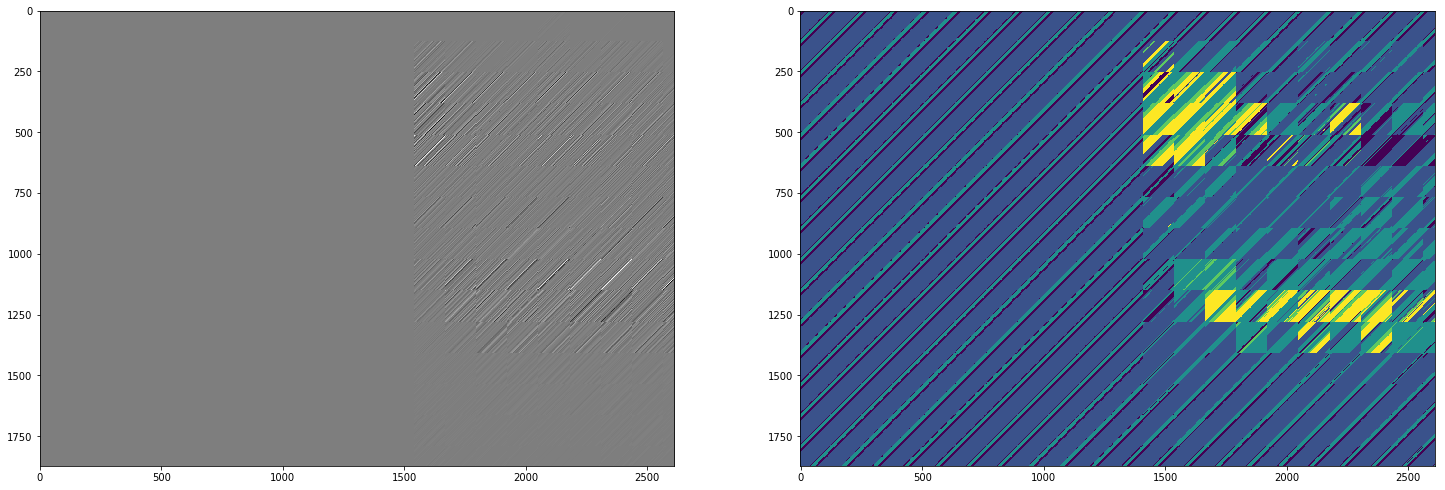

In [219]:
img_full = pred_batch.assembled_cube
pred_full = pred_batch.assembled_pred

fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img_full[:, 0, :].T, cmap='gray')
ax[1].imshow(pred_full[:, 0, :].T)

plt.show()

# Criticism

# Conclusion

# Suggestions for improvments